## The purpose of the Capstone 2 project is to determine whether or not the lesion in an image is malignant or not 

Symmetry, border gradient, and color histogram were measured to determine the malignancy of the lesion in the segmented picture.

import necessary libraries

In [35]:
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [40]:
test=pickle.load(open('testimage',"rb"))

In [41]:
imgname='ISIC_0030102.jpeg'

In [42]:
orig_img=test[imgname][0]
dst=test[imgname][1]
maxContourData=test[imgname][2]
maxContour=test[imgname][3]
mask=test[imgname][4]

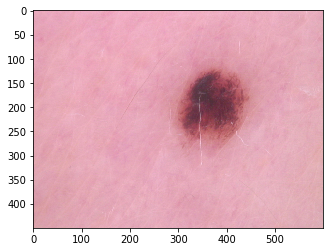

In [43]:
orig_img=cv2.imread(filename, cv2.IMREAD_COLOR)
orig_img = cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)
img=orig_img
plt.imshow(img)

make empty dictionary that will contain all the information of the image

In [32]:
symmetry_dict=dict()
blue_dict=dict()
red_dict=dict()
green_dict=dict()
border_dict=dict()

Check for symmetry: bigger value more malignant

In [6]:
# get angle and center for rotation
(a,b),(MA,ma),angle = cv2.fitEllipse(maxContourData)
print(a,b,MA,ma,angle)
a=int(a)
b=int(b)

368.1972351074219 193.3366241455078 95.59439086914062 114.24609375 38.31223678588867


In [9]:
import numpy as np
def rotate_bound(image, angle,cX,cY):
    # grab the dimensions of the image
    (h, w) = image.shape[:2] 
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [10]:
rotated_roi=rotate_bound(dst,angle,a,b)

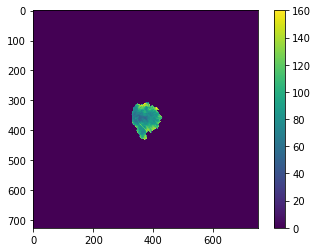

In [13]:
plt.imshow(rotated_roi)
plt.colorbar()

In [14]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(maxContour)
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

(<matplotlib.axes._subplots.AxesSubplot at 0x7f887f7ddeb8>,
 Text(0.5, 1.0, 'UD symmetry'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

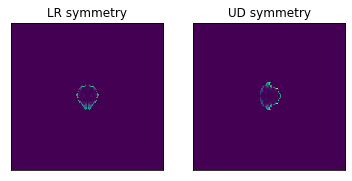

In [15]:
from mpl_toolkits.axes_grid1 import AxesGrid

imageO=rotated_roi
imageLR=np.fliplr(rotated_roi)
imageUD=np.flipud(rotated_roi)
plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

In [16]:
lr=mse(rotated_roi, np.fliplr(rotated_roi))
ud=mse(rotated_roi, np.flipud(rotated_roi))

In [17]:
print((lr+ud)/2)

3434.1258088601294


In [61]:
symmetry_dict[imgname]=(lr+ud)/2

Check Color: bigger value more malignant

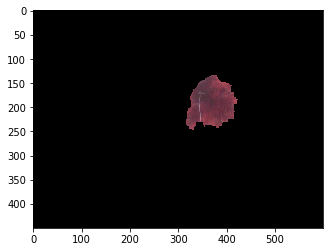

In [62]:
colorcheck = cv2.bitwise_and(orig_img, orig_img, mask=mask)
plt.imshow(colorcheck)

55.71407
92.03419
89.04805


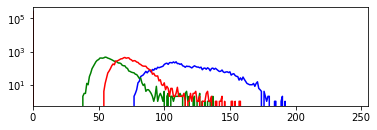

In [63]:
label=imgname.split('.')[0]
color = ('b','g','r')
fig=plt.figure()
zerovalues=list()
ax=fig.add_subplot(2,1,1)
b_list=[]
g_list=[]
r_list=[]
for i,col in enumerate(color):
    histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
    ax.plot(histr,color = col)
    zerovalues.append(histr[0])
    histr=histr[1:]
    plt.xlim([0,255])
    ax.set_yscale('log')
    if col=='b':
        blue_dict[label]=histr.std()
    if col=='g':
        green_dict[label]=histr.std()
    if col=='r':
        red_dict[label]=histr.std()
    print(histr.std())
plt.show()


Check border

In [64]:
def get_mag_ang(img):

    """
    Gets image gradient (magnitude) and orientation (angle)

    Args:
        img

    Returns:
        Gradient, orientation
    """

    img = np.sqrt(img)

    gx = cv2.Sobel(np.float32(img), cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(np.float32(img), cv2.CV_32F, 0, 1)

    mag, ang = cv2.cartToPolar(gx, gy)

    return mag, ang, gx, gy 

In [65]:
H,W = img.shape[:2]
h=20; w=20
tots_gradient=[]
for point in maxContourData[:,0]:
    x=point[0]
    y=point[1]
    #print(x,y)
    y1=y-h; y2=y+h
    x1=x-w; x2=x+w
    if y1<0:
        y1=0
    if y2>H:
        y2=H
    if x1<0:
        x1=0
    if x2>W:
        x2=W
    #print(x1,y1,x2,y2)
    crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
    mag,ang,gx,gy=get_mag_ang(crop_img)
    tots_gradient.append(mag.mean())

border_dict[imgname]=np.mean(tots_gradient)
print(np.mean(tots_gradient))

1.5675288


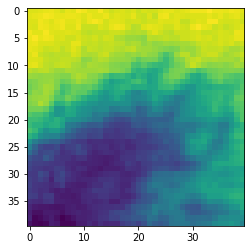

In [66]:
plt.imshow(crop_img)

In [67]:
print(symmetry_dict,blue_dict,red_dict,green_dict,border_dict)

{'ISIC_0030102.jpeg': 3434.1258088601294} {'ISIC_0030102': 55.71407} {'ISIC_0030102': 89.04805} {'ISIC_0030102': 92.03419} {'ISIC_0030102.jpeg': 1.5675288}
